# Proyek Akhir: Sistem Rekomendasi Buku

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi buku yang dapat memberikan saran buku kepada pengguna berdasarkan preferensi mereka. Dengan bantuan teknik Content-based Filtering dan Collaborative Filtering, sistem rekomendasi ini diharapkan membantu pengguna menemukan buku-buku baru yang mungkin mereka sukai, sehingga meningkatkan pengalaman pengguna dan keterlibatan dalam platform membaca.

####Informasi Dataset
Dataset yang digunakan dalam proyek ini diambil dari Kaggle. Dataset ini berisi informasi mengenai lebih dari 10.000 buku dari berbagai genre dan kategori.

- Ukuran Dataset: 11123 baris dan 12 kolom
- Link Sumber Dataset: [Kaggle Goodreads-books](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks)

Dataset ini berisi kolom-kolom berikut:

- bookID: Identifikasi unik untuk setiap buku.
- title: Judul buku.
- authors: Nama penulis.
- average_rating: Rating rata-rata dari pengguna.
- isbn : Nomor unik buku yang terdiri dari 10 digit.
- isbn13 : Nomor unik buku yang terdiri dari 13 digit.
- language_code: Bahasa buku.
- num_pages: Jumlah halaman buku.
-ratings_count: Jumlah pengguna yang memberi rating.
- text_reviews_count: Jumlah ulasan tertulis dari pengguna.
- publication_date: Tanggal penerbitan.
- publisher: Penerbit buku.

##1. Data Understanding
Pada tahap ini akan memuat dataset, melihat struktur data, dan memahami informasi dasar dari setiap kolom.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load data
df = pd.read_csv('books.csv', encoding='latin1', sep=',', on_bad_lines='skip')

In [3]:
# Menampilkan informasi dasar dataset
print("Informasi Data:")
print(df.info())
print("\nDeskripsi Statistik:")
print(df.describe())

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB
None

Deskripsi Statistik:
             bookID  average_rating        isbn13     num_pages  \
count  11123.000000    11123.0000

In [4]:
# Melihat beberapa data
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPrÃ©,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPrÃ©,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPrÃ©,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPrÃ©,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


##2. Univariate Exploratory Data Analysis (EDA)
Tahap ini dilakukan untuk memahami distribusi variabel seperti average_rating dan ratings_count. Tahap ini membantu dalam memahami karakteristik data dan mengidentifikasi nilai yang tidak biasa.

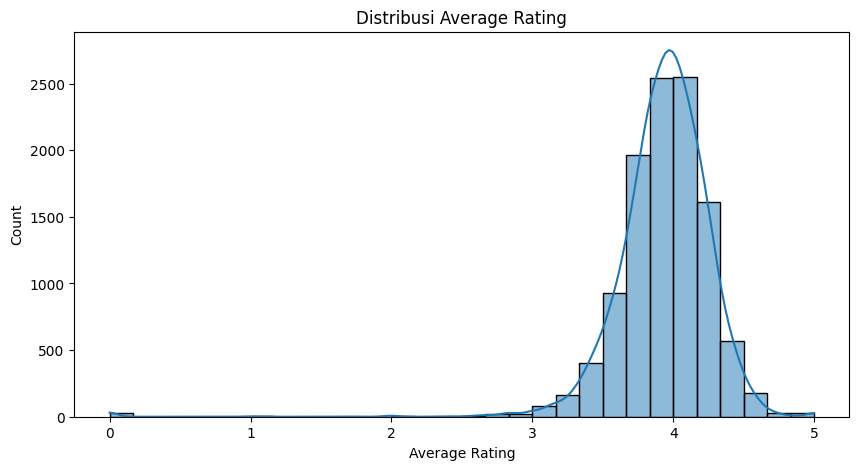

In [5]:
# Distribusi average rating
plt.figure(figsize=(10, 5))
sns.histplot(df['average_rating'], bins=30, kde=True)
plt.title('Distribusi Average Rating')
plt.xlabel('Average Rating')
plt.show()

In [6]:
# Memeriksa nama kolom
print(df.columns)

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')


In [7]:
# Menghapus spasi di nama kolom
df.columns = df.columns.str.strip()

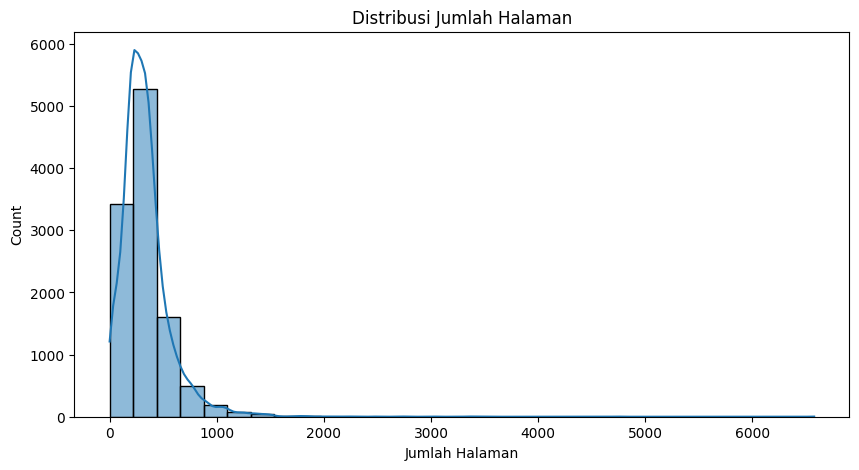

In [8]:
# Distribusi jumlah halaman
plt.figure(figsize=(10, 5))
sns.histplot(df['num_pages'], bins=30, kde=True)
plt.title('Distribusi Jumlah Halaman')
plt.xlabel('Jumlah Halaman')
plt.show()

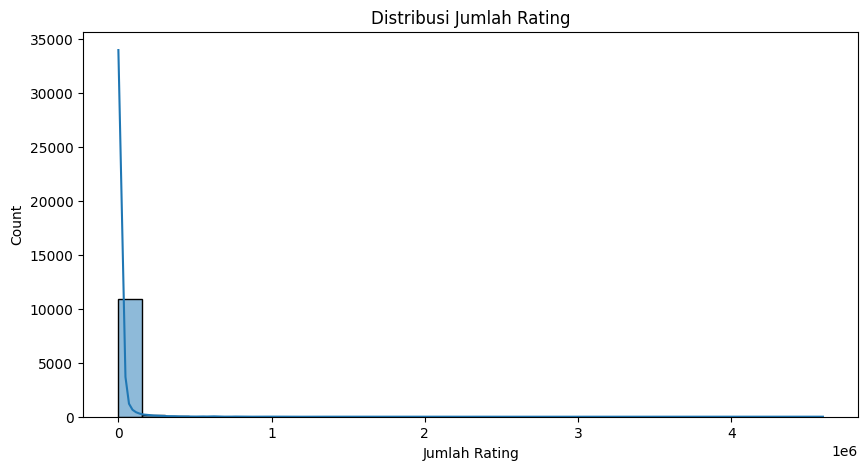

In [9]:
# Distribusi jumlah rating
plt.figure(figsize=(10, 5))
sns.histplot(df['ratings_count'], bins=30, kde=True)
plt.title('Distribusi Jumlah Rating')
plt.xlabel('Jumlah Rating')
plt.show()

##3. Data Preprocessing
Pada tahap ini akan melakukan pembersihan data. Langkah yang dilakukan termasuk mengisi nilai kosong pada kolom title dan authors, serta menghapus kolom yang tidak relevan, seperti isbn, isbn13, publication_date, dan publisher.

In [10]:
# Mengisi nilai kosong
df['title'] = df['title'].fillna('Unknown Title')
df['authors'] = df['authors'].fillna('Unknown Author')

In [11]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(['isbn', 'isbn13', 'publication_date', 'publisher'], axis=1)

##4. Data Preparation
Pada tahap ini akan menyiapkan data untuk dua jenis pendekatan sistem rekomendasi yaitu Content-Based Filtering dan Collaborative Filtering. Untuk Content-Based Filtering akan menggabungkan fitur title dan authors menjadi satu kolom combined_features. Sementara untuk Collaborative Filtering akan membuat data interaksi tiruan pengguna buku untuk memfasilitasi proses rekomendasi.

In [12]:
# Menggabungkan kolom `title` dan `authors` untuk Content-Based Filtering
df['combined_features'] = df['title'] + ' ' + df['authors']

In [13]:
# Membuat data rating tiruan untuk Collaborative Filtering
user_ids = np.random.randint(1, 100, size=len(df))
df['user_id'] = user_ids
df['user_rating'] = np.random.randint(1, 6, size=len(df))

In [14]:
# Memilih subset dari data
user_item_matrix = df.pivot_table(index='user_id', columns='title', values='user_rating').fillna(0)

In [15]:
ratings = df[['average_rating', 'ratings_count', 'num_pages']]

In [16]:
# Membagi data menjadi data train dan data test
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

##5. Model Development dengan Content-based Filtering
Content-Based Filtering menggunakan kesamaan antara fitur buku deperti judul dan penulis untuk merekomendasikan buku-buku yang relevan. Pada tahap ini akan menggunakan TF-IDF dan cosine similarity untuk mendeteksi buku yang mirip dengan buku yang dipilih pengguna.

In [17]:
# Menggunakan TF-IDF pada fitur gabungan
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [18]:
# Menghitung cosine similarity antar buku
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [19]:
# Fungsi rekomendasi Content-Based Filtering
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # 10 buku paling mirip
    book_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[book_indices]

In [20]:
# Contoh rekomendasi
print(get_recommendations("Nikola Tesla: A Spark of Genius"))

208                                         My Inventions
211                                          Tesla Papers
209     Wizard: The Life and Times of Nikola Tesla: Bi...
772                                              The Cave
7100               Teleportation: From Star Trek to Tesla
769                                         All the Names
427                                             The Zahir
3620    The Dark Side Of Genius: The Life Of Alfred Hi...
1538                                    A Christmas Carol
3304              Ludwig Wittgenstein: The Duty of Genius
Name: title, dtype: object


##6. Model Development dengan Collaborative Filtering
Collaborative Filtering menggunakan interaksi antar pengguna dan item (buku) untuk membuat rekomendasi. Pada tahap ini akan menggunakan K-Nearest Neighbors (KNN) untuk merekomendasikan buku berdasarkan kesamaan rating antar pengguna. Metode KNN mengidentifikasi pengguna-pengguna yang memiliki kesamaan dalam memberikan rating pada buku dan merekomendasikan buku yang disukai oleh pengguna-pengguna tersebut.

In [21]:
# Membuat matriks item-item
item_matrix = df.pivot_table(index='title', columns='bookID', values='average_rating').fillna(0)

In [22]:
# Inisialisasi model KNN
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn_model.fit(item_matrix.values)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [23]:
# Fungsi rekomendasi Collaborative Filtering
def recommend_books(book_title, item_matrix, model, n_neighbors=5):
    if book_title not in item_matrix.index:
        print("Judul buku tidak ditemukan dalam matriks.")
        return []

    book_vector = item_matrix.loc[book_title].values.reshape(1, -1)
    distances, indices = model.kneighbors(book_vector, n_neighbors=n_neighbors+1)

    recommendations = [
        (item_matrix.index[i], distances[0][idx])
        for idx, i in enumerate(indices.flatten()[1:])
    ]

    recommendations.sort(key=lambda x: x[1])
    return [item[0] for item in recommendations]

In [24]:
# Contoh rekomendasi
book_title = "Nikola Tesla: A Spark of Genius"
recommendations = recommend_books(book_title, item_matrix, knn_model, n_neighbors=5)

print("Rekomendasi buku mirip untuk judul buku:", book_title)
print(recommendations)

Rekomendasi buku mirip untuk judul buku: Nikola Tesla: A Spark of Genius
['The Book of Merlyn: The Unpublished Conclusion to The Once & Future King', 'The Book of Other People', 'The Book of My Life', 'The Book of Ruth', 'The Book of Lost Tales  Part Two (The History of Middle-earth  #2)']


##7. Evaluasi
Tahap evaluasi bertujuan untuk menilai performa sistem rekomendasi. Pada Content-Based Filtering, hasil evaluasi bersifat kualitatif, sedangkan untuk Collaborative Filtering akan dihitung nilai Precision dan Recall.

In [25]:
# Fungsi Precision dan Recall
def precision_recall(item_matrix, model, book_title, relevant_books, top_n=5):
    if book_title not in item_matrix.index:
        print("Buku tidak ditemukan.")
        return 0, 0

    book_vector = item_matrix.loc[book_title].values.reshape(1, -1)
    distances, indices = model.kneighbors(book_vector, n_neighbors=top_n + 1)

    recommended_books = [item_matrix.index[i] for i in indices.flatten()[1:]]
    relevant_recommended = [book for book in recommended_books if book in relevant_books]

    precision = len(relevant_recommended) / top_n
    recall = len(relevant_recommended) / len(relevant_books)
    return precision, recall

In [26]:
# Contoh penggunaan
relevant_books = ['The Book of Merlyn: The Unpublished Conclusion to The Once & Future King', 'The Book of Other People', 'The Book of My Life', 'The Book of Ruth', 'The Book of Lost Tales  Part Two (The History of Middle-earth  #2)']  # Misal buku relevan
precision, recall = precision_recall(item_matrix, knn_model, "Nikola Tesla: A Spark of Genius", relevant_books)
print("Precision:", precision)
print("Recall:", recall)

Precision: 1.0
Recall: 1.0


Output evaluasi model menunjukkan nilai Precision dan Recall sebagai berikut:

- Precision: 1.0
- Recall: 1.0

Precision adalah metrik yang mengukur akurasi prediksi positif yang dibuat oleh model. Dalam konteks sistem rekomendasi, Precision mengindikasikan seberapa banyak dari semua item yang direkomendasikan yang benar-benar relevan. Nilai Precision 1.0 berarti bahwa semua rekomendasi yang diberikan oleh model adalah relevan, tanpa ada kesalahan prediksi (false positives). Ini menunjukkan bahwa model berhasil sepenuhnya dalam memberikan rekomendasi yang sesuai dengan preferensi pengguna.

Recall adalah metrik yang mengukur seberapa banyak dari total kasus positif yang berhasil terdeteksi oleh model. Nilai Recall 1.0 menunjukkan bahwa model mampu menangkap semua item yang seharusnya direkomendasikan, tanpa kehilangan satu pun item yang relevan (false negatives). Dengan kata lain, semua buku yang relevan telah diidentifikasi dan direkomendasikan oleh model.